In [51]:
###-----------------
### Import Libraries
###-----------------

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn import datasets
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
%matplotlib inline

In [52]:
###----------------
### Some parameters
###----------------

RANDOM_STATE = 24 # REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE)
rng = np.random.default_rng(seed = RANDOM_STATE) # Set Random Seed for reproducible  results

NOISE = 0.2
EPOCHS = 10001  # number of epochs
ALPHA = 0.1  # learning rate
N_SAMPLES = 1000
TEST_SIZE = 0.2
# parameters for Matplotlib
params = {'legend.fontsize': 'medium',
          'figure.figsize': (15, 6),
          'axes.labelsize': 'large',
          'axes.titlesize':'large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large'
         }

plt.rcParams.update(params)

CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

In [53]:
X ,y = datasets.make_moons(n_samples=N_SAMPLES,
                           shuffle=True,
                           noise=NOISE,
                           random_state=RANDOM_STATE)

X.shape,y.shape

((1000, 2), (1000,))

In [54]:
y=pd.get_dummies(y).to_numpy()
X.shape,y.shape

((1000, 2), (1000, 2))

In [55]:
X_train, X_test ,y_train, y_test =train_test_split(X,y,random_state=RANDOM_STATE,stratify=y,test_size=TEST_SIZE )



## Multilayer Perceptron using  SoftMax at output layer and Tanh as a activation function at hidden layer

### Tanh Activation

In [56]:
def fn_actv(z):
    return np.tanh(z)

def fn_actv_prime(a):
    return 1-np.tanh(a)**2


# Softamx Acitivation

In [57]:

def fn_softmax(z):
    exp_sc = np.exp(z)
    return (exp_sc/np.sum(exp_sc,axis=1,keepdims=True))

In [58]:
pred = fn_softmax(np.array([[8,5,1],[-10,0,10]]))
pred

array([[9.51747406e-01, 4.73847131e-02, 8.67881295e-04],
       [2.06106005e-09, 4.53978686e-05, 9.99954600e-01]])

In [59]:
pred.sum(axis=1)

array([1., 1.])

# Loss Calculation

In [60]:
def calculate_loss(model,X,y):
    w1,w2,w3,b1,b2,b3 = model['W1'],model['W2'],model['W3'],model['b1'],model['b2'],model['b3']
    m = X.shape[0]
            #Layer 1
    z1 = X.dot(w1)+b1
    a1 = fn_actv(z1)
            
            #Layer 2
    z2 = a1.dot(w2)+b2
    a2 = fn_actv(z2)

            #Layer 3
    z3 = a2.dot(w3)+b3
    a3 = fn_softmax(z3)

    data_loss = -(y*np.log(a3)+ (1-y)*np.log(1-a3)).sum()

    return  1./m*data_loss

### Prediciton

In [61]:
def predict(model,X):
    
    w1,w2,w3,b1,b2,b3 = model['W1'],model['W2'],model['W3'],model['b1'],model['b2'],model['b3']
            
            #Layer 1
    z1 = X.dot(w1)+b1
    a1 = fn_actv(z1)
            
            #Layer 2
    z2 = a1.dot(w2)+b2
    a2 = fn_softmax(z2)

            #Layer 3
    z3 = a2.dot(w3)+b3
    a3 = fn_softmax(z3)

    return np.argmax(a3,axis=1)

In [62]:
nn_input_dim =X_train.shape[1]
nn_hdim = 4
nn_output_dim=2
hist={}

# Training

In [63]:
def build_model(X,y, alpha=ALPHA, n_epoch=EPOCHS):
    w1 = np.random.rand(nn_input_dim,nn_hdim)/np.sqrt(nn_input_dim)
    w2 = np.random.rand(nn_hdim,nn_hdim)/np.sqrt(nn_input_dim)
    w3 = np.random.rand(nn_hdim,nn_output_dim)/np.sqrt(nn_input_dim)

    b1 = np.zeros((1,nn_hdim)) 
    b2 = np.zeros((1,nn_hdim)) 
    b3 = np.zeros((1,nn_output_dim)) 

    curr_loss=0
    loss ,epoch =[],[]
    m=X.shape[0]
    errors=[]
    for i in range(n_epoch):
        #forward propagation
            
        #Layer 1train
        z1 = X.dot(w1)+b1
        a1 = fn_actv(z1)
                
                #Layer 2
        z2 = a1.dot(w2)+b2
        a2 = fn_actv(z2)
                
                #Layer 3
        z3 = a2.dot(w3)+b3
        a3 = fn_softmax(z3)

        #######################
        #Back propagation       
        #Layer 3
        dz3 = a3-y

        assert(z3.shape == dz3.shape),f'error z3 {z3.shape}/{dz3.shape})'

        dw3 =( a2.T).dot(dz3)
        assert(w3.shape == dw3.shape),f'error w3 {w3.shape}/{dw3.shape}'

        db3 =np.sum(dz3,axis=0,keepdims=True)
        assert(b3.shape == db3.shape),f'error b3 {b3.shape}/{db3.shape}'

        da2 = dz3.dot(w3.T)

        #Layer 2
        
        dz2 = da2*fn_actv_prime(z2)
        
        assert(z2.shape == dz2.shape),f'error z2 {z2.shape}/{dz2.shape})'

        dw2 =( a1.T).dot(dz2)
        assert(w2.shape == dw2.shape),f'error w2 {w2.shape}/{dw2.shape}'

        db2 =np.sum(dz2,axis=0,keepdims=True)
        assert(b2.shape == db2.shape),f'error b2 {b2.shape}/{db2.shape}'

        da1 = dz2.dot(w2.T)

        #Layer 1
        dz1 = da1*fn_actv_prime(z1)

        dw1 =( X.T).dot(dz1)
        assert(w1.shape == dw1.shape),f'error w1 {w1.shape}/{dw1.shape}'

        db1 =np.sum(dz1,axis=0,keepdims=True)
        assert(b1.shape == db1.shape),f'error b1 {b1.shape}/{db1.shape}'

        w1 += -alpha*dw1/m #gradient update
        w2 += -alpha*dw2/m #gradient update
        w3 += -alpha*dw3/m #gradient update
        b1 += -alpha*db1/m #gradient update
        b2 += -alpha*db2/m #gradient update
        b3 += -alpha*db3/m #gradient update

        model ={'W1':w1, 'W2':w2,'W3':w3,'b1':b1,'b2':b2,'b3':b3 }

        if i%100==0:
            curr_loss = calculate_loss(model,X,y)
            loss.append(curr_loss)
            epoch.append(i)
            print (f'Epoch {i} :  Current loss : {curr_loss  : .5f}')
        
        
        hist['loss']=loss
        hist['epochs']=epoch
    return model

In [64]:
model = build_model(X_train,y_train)

Epoch 0 :  Current loss :  1.40018
Epoch 100 :  Current loss :  1.31201
Epoch 200 :  Current loss :  0.80648
Epoch 300 :  Current loss :  0.64476
Epoch 400 :  Current loss :  0.62992
Epoch 500 :  Current loss :  0.61385
Epoch 600 :  Current loss :  0.56868
Epoch 700 :  Current loss :  0.46828
Epoch 800 :  Current loss :  0.35463
Epoch 900 :  Current loss :  0.27601
Epoch 1000 :  Current loss :  0.22986
Epoch 1100 :  Current loss :  0.20260
Epoch 1200 :  Current loss :  0.18572
Epoch 1300 :  Current loss :  0.17472
Epoch 1400 :  Current loss :  0.16723
Epoch 1500 :  Current loss :  0.16194
Epoch 1600 :  Current loss :  0.15809
Epoch 1700 :  Current loss :  0.15522
Epoch 1800 :  Current loss :  0.15303
Epoch 1900 :  Current loss :  0.15132
Epoch 2000 :  Current loss :  0.14996
Epoch 2100 :  Current loss :  0.14886
Epoch 2200 :  Current loss :  0.14796
Epoch 2300 :  Current loss :  0.14721
Epoch 2400 :  Current loss :  0.14657
Epoch 2500 :  Current loss :  0.14602
Epoch 2600 :  Current lo

<Axes: xlabel='epochs'>

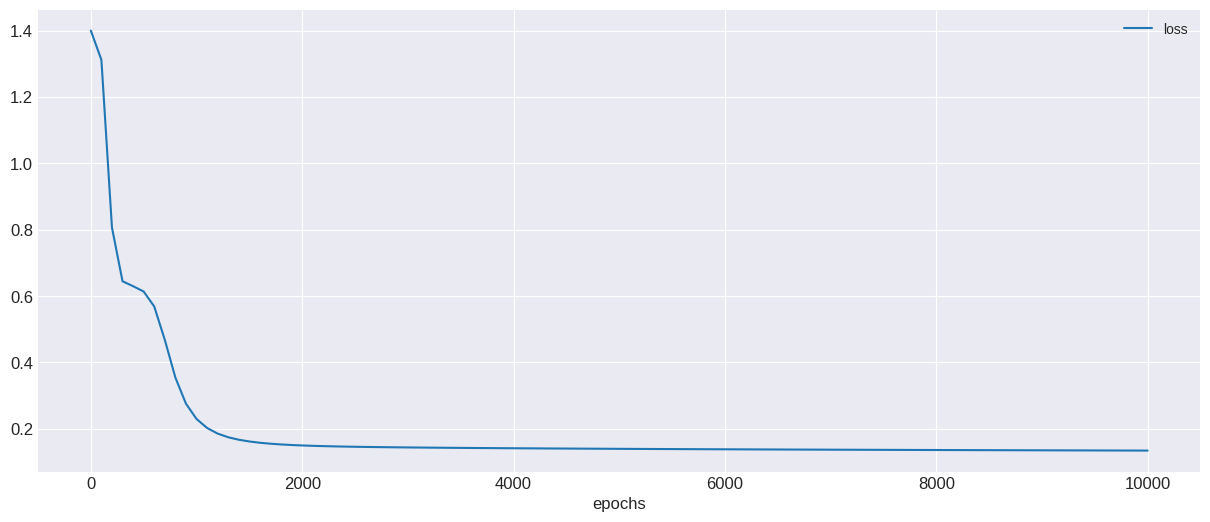

In [65]:
pd.DataFrame(hist).plot(x = 'epochs')

In [66]:
y_pred = predict(model, X_train)
print('Accuracy score on Train Data :', accuracy_score(y_train, y_pred))

ValueError: Classification metrics can't handle a mix of multilabel-indicator and binary targets

In [ ]:
y_train.shape

(800, 2)

In [ ]:
def fn_plot_decision_boundary(predict,X_tr,y_tr,X_ts,y_ts):
    
    # initialize the figure
    fig, ax = plt.subplots(figsize = (8,5))
   
    
    # Range of X values (First feature)
    x_min, x_max = X_tr[:, 0].min() - 0.05, X_tr[:, 0].max() + 0.05
    
    # Range of Y values (Second feature)
    y_min, y_max = X_tr[:, 1].min() - 0.05, X_tr[:, 1].max() + 0.05
    
    h=0.01
    # Create a grid to evaluate the object function
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    z= predict((np.c_[xx.ravel(),yy.ravel()]))

    z=z.reshape(xx.shape)
    fig = plt.figure()
    ax = fig.add_axes(111)
    ax.contourf(xx,yy,z,cmap=CMAP,)
    ax.scatter(X_tr[:,0],X_tr[:,1],c=np.argmax(y_tr,axis=1),s=30,edgecolor='k',cmap=plt.cm.coolwarm)
    ax.scatter(X_ts[:,0],X_ts[:,1],c=np.argmax(y_ts,axis=1),s=30,marker='*',edgecolor='k',cmap=plt.cm.inferno)

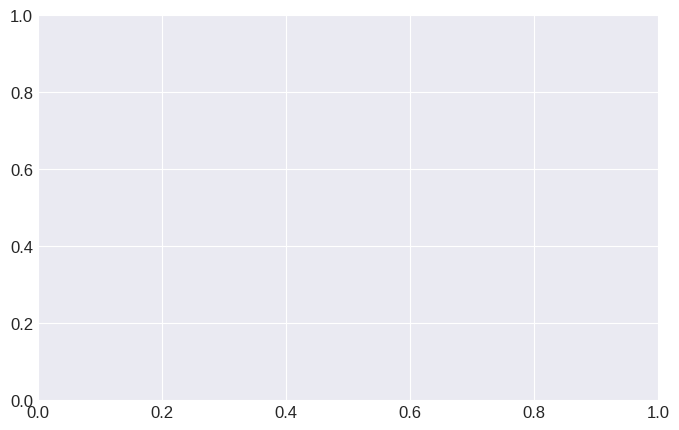

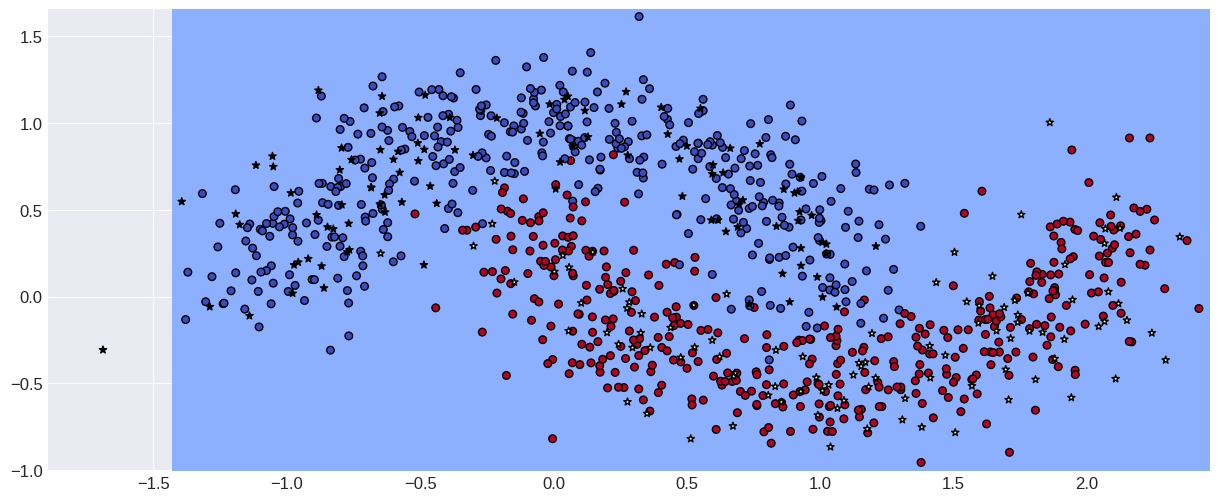

In [ ]:
fn_plot_decision_boundary(lambda x:predict(model,x),X_train,y_train,X_test,y_test)